# Importo librerias

In [17]:
pip install scikeras 

Note: you may need to restart the kernel to use updated packages.


In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import tensorflow.keras as keras
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV


# Defino diccionarios para guardar los datos de los entrenamientos y las pruebas

In [19]:

### Creo listas para guardar los resultados de los modelos
histories = {}
metrics_dict = {}
predicciones_dict = {}

# Preparo los datos y los escalo

In [20]:
# 1. Descargar datos de yfinance
stock_1 = "BDORY"
stock_2 = "^BVSP"
fecha_inicial = "2020-05-31"  # Fecha histórica
fecha_final = "2025-03-31"    # Fecha actual

df_yf = yf.download(
    tickers=(stock_1, stock_2),
    start=fecha_inicial,
    end=fecha_final,
    interval="1d",
    group_by='ticker',
    auto_adjust=True
)
if df_yf.empty:
	df_yf = pd.read_csv('df_yfinance_raw.csv', header=[0,1], index_col=0, parse_dates=True)
 
df_yf.head()

# 2. Crear DataFrame con regresores y características adicionales
df = pd.DataFrame({
    'y': df_yf[stock_1]['Close'],
    'bvsp_lag5': df_yf[stock_2]['Close'].shift(5)    
})
df = df.dropna().reset_index(drop=True)

# Eliminar filas con valores nulos
df.dropna(inplace=True)

print("\nDatos descargados y preprocesados:")
print(df.head())

[*********************100%***********************]  2 of 2 completed


Datos descargados y preprocesados:
          y  bvsp_lag5
0  2.583213    88620.0
1  2.528686    91046.0
2  2.446895    93002.0
3  2.191301    93829.0
4  2.245828    94637.0


# LSTM basic model

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 25, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,593 (463.25 KB)

 Trainable params: 118,593 (463.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.1639 - val_loss: 0.0447
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0413 - val_loss: 0.0110
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0274 - val_loss: 0.0495
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0206 - val_loss: 0.0091
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0129 - val_loss: 0.0081
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0117 - val_loss: 0.0133
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0110 - val_loss: 0.0039
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0088 - val_loss: 0.0040
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0090 - val_loss: 0.0071
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0083 - val_loss: 0.0026
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0069 - val_loss: 0.0026
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0073 - val_lo

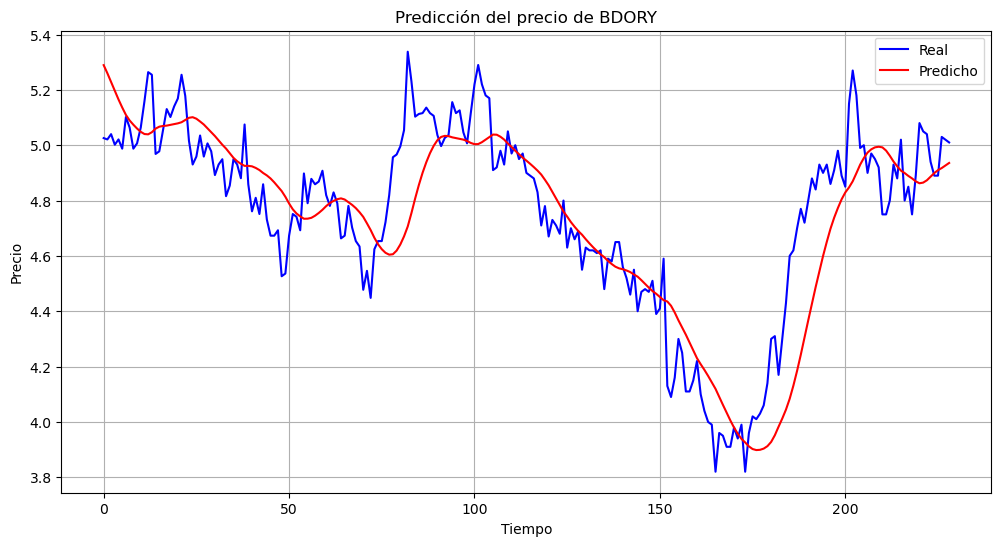

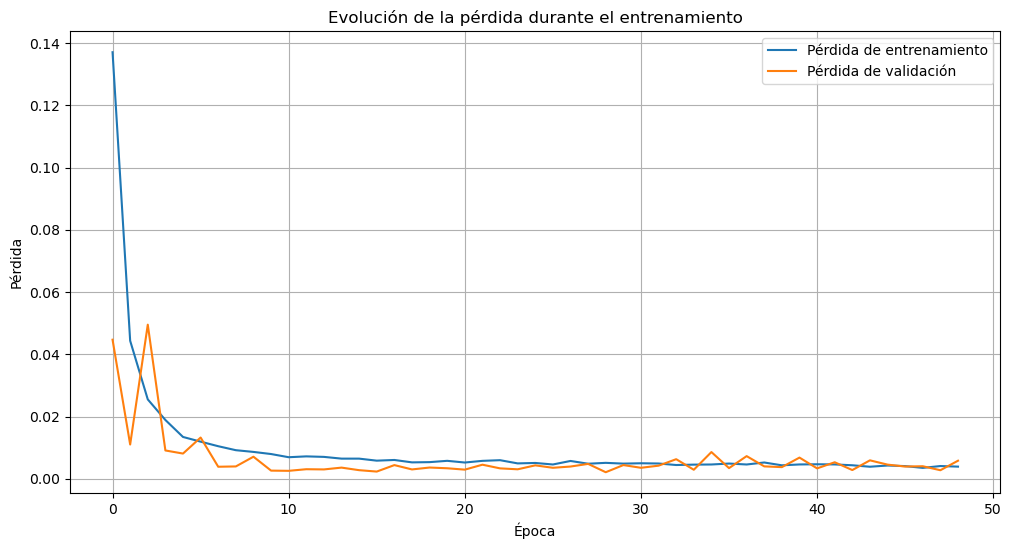

In [21]:

# 3. Normalizar los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
def create_sequences(data, seq_length): 
	X, y = [], [] 
	for i in range(seq_length, len(data)):
		X.append(data[i-seq_length:i, :])
		y.append(data[i, 0])  # columna 0 es el precio de cierre de BDORY
	return np.array(X), np.array(y)	
sequence_length = 25  # Aumentado para capturar más contexto
X, y = create_sequences(scaled_data, sequence_length)

# 5. Separar en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# 6. Construir modelo LSTM mejorado
model_basic = Sequential([
	Input(shape=(X.shape[1], X.shape[2])),  # Add this as the first layer
	LSTM(128, return_sequences=True),
	Dropout(0.5),
	LSTM(64, return_sequences=False),
	Dropout(0.5),
	Dense(32, activation='relu'),
	Dense(1)
])
model_basic.summary()

# Configurar early stopping
callbacks = [
	# detiene el entrenamiento si no hay mejora en la validación
	EarlyStopping(monitor='val_loss', patience=20,restore_best_weights=True),
	# ajusta el learning rate si no hay mejora en la validación
	#ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5) 
]

model_basic.compile(optimizer='adam', loss='mse')
history = model_basic.fit(
	X_train, y_train,
	epochs=100,
	batch_size=256,
	validation_data=(X_test, y_test),
	callbacks=callbacks,
	verbose=1
)

# Guardar el historial de entrenamiento
histories['LSTM_simple'] = history.history

# 7. Predicciones y desnormalización
predicted = model_basic.predict(X_test)
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.zeros((len(y_test),scaled_data.shape[1]-1))), axis=1))[:,0]
predicted_actual = scaler.inverse_transform(np.concatenate((predicted, np.zeros((len(predicted),scaled_data.shape[1]-1))), axis=1))[:,0]

# Guardar las predicciones en el diccionario
predicciones_dict['LSTM_simple'] = {'y_test_actual': y_test_actual, 'predicted_actual': predicted_actual}

# 8. Evaluación del modelo
mse = mean_squared_error(y_test_actual, predicted_actual)
mae = mean_absolute_error(y_test_actual, predicted_actual)
r2 = r2_score(y_test_actual, predicted_actual)

# Guardar las métricas en el diccionario
metrics_dict['LSTM_simple'] = {'MSE': mse, 'MAE': mae, 'R2': r2}

print(f"\nMétricas de evaluación:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

# 9. Visualización
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Real', color='blue')
plt.plot(predicted_actual, label='Predicho', color='red')
plt.title('Predicción del precio de BDORY')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

# 10. Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

# LSTM con más datos

Agregamos datos adicionales
- Precio de apertura
- Volumen
- Precio máximo
- Precio mínimo
- Volatilidad
- Precio de cierre
- Porcentaje de cambio
- Media de 5
- Media de 20

[*********************100%***********************]  2 of 2 completed


Datos descargados y preprocesados:
           y  bvsp_lag5  volume_BDORY  high_BDORY  low_BDORY  open_BDORY  \
19  2.119733    95056.0      415400.0    2.218563   2.116325    2.211747   
20  2.215156    96203.0      465800.0    2.215156   2.119733    2.160629   
21  2.201524    96235.0      233600.0    2.218564   2.153813    2.218564   
22  2.198116    96765.0      234000.0    2.201524   2.146997    2.146997   
23  2.187893    98937.0      437800.0    2.218564   2.133366    2.218564   

     returns  volatility       ma5      ma20  
19 -0.044547    0.038606  2.127231  2.207829  
20  0.045016    0.037922  2.162674  2.189426  
21 -0.006154    0.036231  2.178350  2.173068  
22 -0.001548    0.036482  2.190619  2.160629  
23 -0.004651    0.031798  2.184484  2.160458  


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 25, 128)        │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,689 (479.25 KB)

 Trainable params: 122,689 (479.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.1128 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0336 - val_loss: 0.0325 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0168 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0141 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0117 - val_loss: 0.0187 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0107 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0108 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0092 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0087 - val_loss: 0.0118 - learning_rate: 5.0000e-04
Epoch 10/100
4/4 ━━━━━━

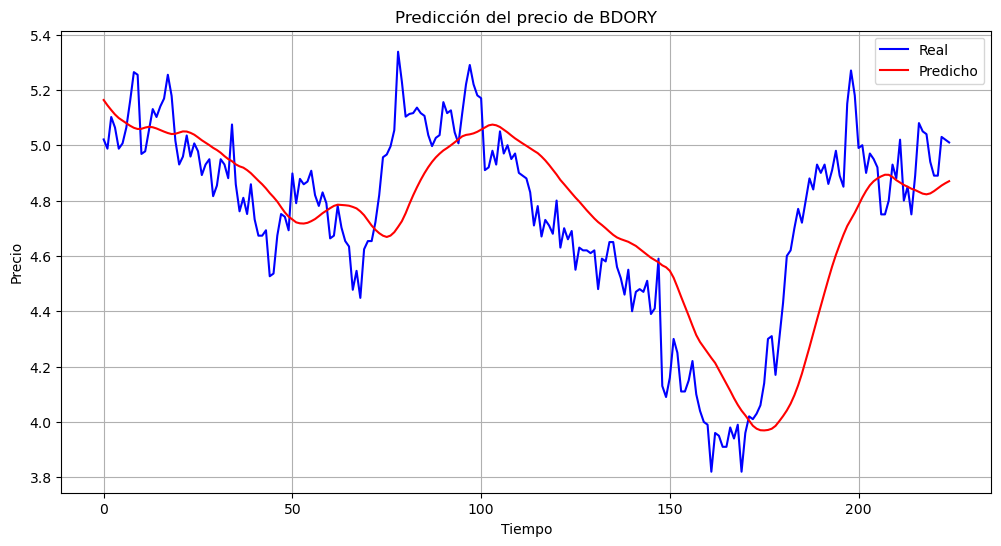

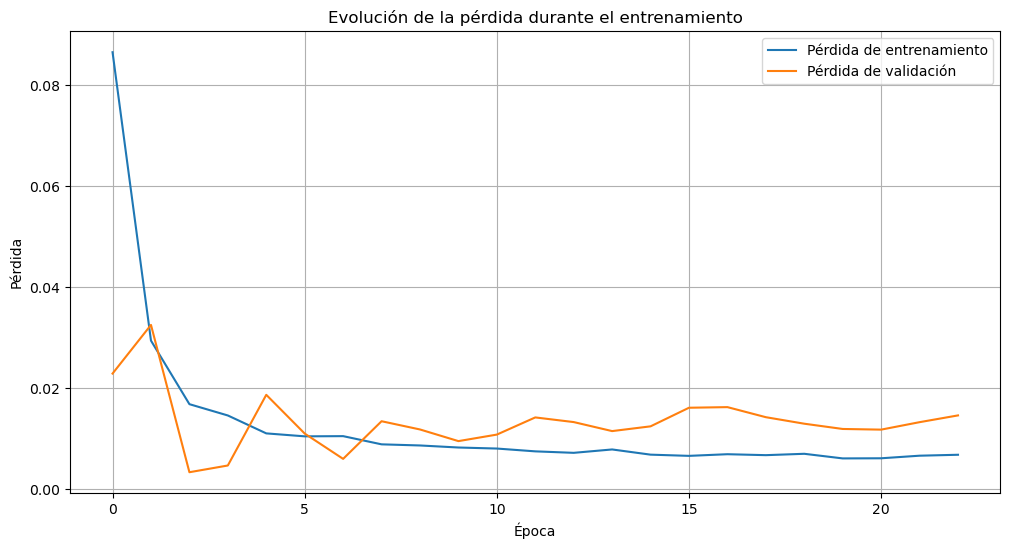

In [22]:
# 1. Descargar datos de yfinance
stock_1 = "BDORY"
stock_2 = "^BVSP"
fecha_inicial = "2020-05-31"  # Fecha histórica
fecha_final = "2025-03-31"    # Fecha actual

df_yf = yf.download(
    tickers=(stock_1, stock_2),
    start=fecha_inicial,
    end=fecha_final,
    interval="1d",
    group_by='ticker',
    auto_adjust=True
)
if df_yf.empty:
	df_yf = pd.read_csv('df_yfinance_raw.csv', header=[0,1], index_col=0, parse_dates=True)

# 2. Crear DataFrame con regresores y características adicionales
df = pd.DataFrame({
    'y': df_yf[stock_1]['Close'],
    'bvsp_lag5': df_yf[stock_2]['Close'].shift(5),
    'volume_BDORY': df_yf[stock_1]['Volume'],
    'high_BDORY': df_yf[stock_1]['High'],
    'low_BDORY': df_yf[stock_1]['Low'],
    'open_BDORY': df_yf[stock_1]['Open']
})
df = df.dropna().reset_index(drop=True)

# Agregar características técnicas
df['returns'] = df['y'].pct_change()
df['volatility'] = df['returns'].rolling(window=5).std()
df['ma5'] = df['y'].rolling(window=5).mean()
df['ma20'] = df['y'].rolling(window=20).mean()

# Eliminar filas con valores nulos
df.dropna(inplace=True)

print("\nDatos descargados y preprocesados:")
print(df.head())

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 4. Crear secuencias para LSTM
def create_sequences(data, seq_length):
	X, y = [], []
	for i in range(seq_length, len(data)):
		X.append(data[i-seq_length:i, :])
		y.append(data[i, 0])  # columna 0 es el precio de cierre de BDORY
	return np.array(X), np.array(y)

sequence_length = 25  # Aumentado para capturar más contexto
X, y = create_sequences(scaled_data, sequence_length)

# 5. Separar en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 6. Construir modelo LSTM mejorado
model_mas_datos = Sequential([
	Input(shape=(X.shape[1], X.shape[2])),  # Add this as the first layer
	LSTM(128, return_sequences=True),
	Dropout(0.5),
	LSTM(64, return_sequences=False),
	Dropout(0.5),
	Dense(32, activation='relu'),
	Dense(1)
])
# Mostrar el resumen del modelo
model_mas_datos.summary()

# Configurar early stopping
callbacks = [
	# detiene el entrenamiento si no hay mejora en la validación
	EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
	# ajusta el learning rate si no hay mejora en la validación
	ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5) 
]

model_mas_datos.compile(optimizer='adam', loss='mse')	

history = model_mas_datos.fit(
	X_train, y_train,
	epochs=100,
	batch_size=256,
	validation_data=(X_test, y_test),
	callbacks=callbacks,
	verbose=1
)
 
# Guardar el historial de entrenamiento
histories['LSTM_mas_datos'] = history.history

# 7. Predicciones y desnormalización
predicted = model_mas_datos.predict(X_test)
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.zeros((len(y_test),scaled_data.shape[1]-1))), axis=1))[:,0]
predicted_actual = scaler.inverse_transform(np.concatenate((predicted, np.zeros((len(predicted),scaled_data.shape[1]-1))), axis=1))[:,0]

# Guardar las predicciones en el diccionario
predicciones_dict['LSTM_mas_datos'] = {'y_test_actual': y_test_actual, 'predicted_actual': predicted_actual}

# 8. Evaluación del modelo
mse = mean_squared_error(y_test_actual, predicted_actual)
mae = mean_absolute_error(y_test_actual, predicted_actual)
r2 = r2_score(y_test_actual, predicted_actual)

# Guardar las métricas en el diccionario
metrics_dict['LSTM_mas_datos'] = {'MSE': mse, 'MAE': mae, 'R2': r2}

print(f"\nMétricas de evaluación:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

# 9. Visualización
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Real', color='blue')
plt.plot(predicted_actual, label='Predicho', color='red')
plt.title('Predicción del precio de BDORY')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

# 10. Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

# LSTM con gridsearch

In [23]:
# 1. Descargar datos de yfinance
stock_1 = "BDORY"
stock_2 = "^BVSP"
fecha_inicial = "2020-05-31"  # Fecha histórica
fecha_final = "2025-03-31"    # Fecha actual

df_yf = yf.download(
    tickers=(stock_1, stock_2),
    start=fecha_inicial,
    end=fecha_final,
    interval="1d",
    group_by='ticker',
    auto_adjust=True
)
if df_yf.empty:
	df_yf = pd.read_csv('df_yfinance_raw.csv', header=[0,1], index_col=0, parse_dates=True)

# 2. Crear DataFrame con regresores y características adicionales
df = pd.DataFrame({
    'y': df_yf[stock_1]['Close'],
    'bvsp_lag5': df_yf[stock_2]['Close'].shift(5),
    'volume_BDORY': df_yf[stock_1]['Volume'],
    'high_BDORY': df_yf[stock_1]['High'],
    'low_BDORY': df_yf[stock_1]['Low'],
    'open_BDORY': df_yf[stock_1]['Open']
})
df = df.dropna().reset_index(drop=True)

# Agregar características técnicas
df['returns'] = df['y'].pct_change()
df['volatility'] = df['returns'].rolling(window=5).std()
df['ma5'] = df['y'].rolling(window=5).mean()
df['ma20'] = df['y'].rolling(window=20).mean()

# Eliminar filas con valores nulos
df.dropna(inplace=True)

print("Datos descargados y procesados:")
print(df.head())

# 3. Normalizar los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 4. Crear secuencias para LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :])
        y.append(data[i, 0])  # columna 0 es el precio de cierre de BDORY
    return np.array(X), np.array(y)

sequence_length = 25  # Aumentado para capturar más contexto
X, y = create_sequences(scaled_data, sequence_length)

# 5. Separar en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

[*********************100%***********************]  2 of 2 completed

Datos descargados y procesados:
           y  bvsp_lag5  volume_BDORY  high_BDORY  low_BDORY  open_BDORY  \
19  2.119733    95056.0      415400.0    2.218563   2.116325    2.211747   
20  2.215156    96203.0      465800.0    2.215156   2.119733    2.160629   
21  2.201524    96235.0      233600.0    2.218564   2.153813    2.218564   
22  2.198116    96765.0      234000.0    2.201524   2.146997    2.146997   
23  2.187893    98937.0      437800.0    2.218564   2.133366    2.218564   

     returns  volatility       ma5      ma20  
19 -0.044547    0.038606  2.127231  2.207829  
20  0.045016    0.037922  2.162674  2.189426  
21 -0.006154    0.036231  2.178350  2.173068  
22 -0.001548    0.036482  2.190619  2.160629  
23 -0.004651    0.031798  2.184484  2.160458  


## Defino el grid search

In [24]:
def build_model(units=128, dropout=0.2, lr=0.001):
    model_grid = Sequential()
    model_grid.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model_grid.add(Dropout(dropout))
    model_grid.add(Dense(1))    
    model_grid.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model_grid   


In [25]:
# KerasRegressor is used to wrap the Keras model for use in scikit-learn pipelines
regressor = KerasRegressor(build_fn=build_model, verbose=0, dropout=0.2, lr=0.0005, units=64)


In [26]:
param_grid = {
    'units': [32, 64, 128, 256],
    'dropout': [0.2, 0.5],
    'lr': [0.01, 0.0005],
    'epochs': [20, 200],
    'batch_size': [4, 64]
}

In [27]:
grid = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
#grid_result = grid.fit(X_train, y_train)

In [28]:
#print("Mejor score: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))


## Corro con los mejores parametros

In [29]:
# Seteo los mejores hiperparámetros encontrados
#batch_size=16
#dropout=0.2
#epochs=50
#lr=0.0005
#units=128

In [30]:
# Seteo los mejores hiperparámetros encontrados
#batch_size=4
#dropout=0.2
#epochs=20
#lr=0.001
#units=256

In [31]:
# Seteo los mejores hiperparámetros encontrados
batch_size=4
dropout=0.2
epochs=200
lr=0.0005
units=256

[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/ia_ceia_18co/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


           y  bvsp_lag5  volume_BDORY  high_BDORY  low_BDORY  open_BDORY  \
19  2.119733    95056.0      415400.0    2.218563   2.116325    2.211747   
20  2.215156    96203.0      465800.0    2.215156   2.119733    2.160629   
21  2.201524    96235.0      233600.0    2.218564   2.153813    2.218564   
22  2.198116    96765.0      234000.0    2.201524   2.146997    2.146997   
23  2.187893    98937.0      437800.0    2.218564   2.133366    2.218564   

     returns  volatility       ma5      ma20  
19 -0.044547    0.038606  2.127231  2.207829  
20  0.045016    0.037922  2.162674  2.189426  
21 -0.006154    0.036231  2.178350  2.173068  
22 -0.001548    0.036482  2.190619  2.160629  
23 -0.004651    0.031798  2.184484  2.160458  
El modelo no existe. Creando un nuevo modelo...
Epoch 1/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0121 - val_loss: 0.0142
Epoch 2/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 3/200
225/225 ━━━━━━━━━━━━━━━━━

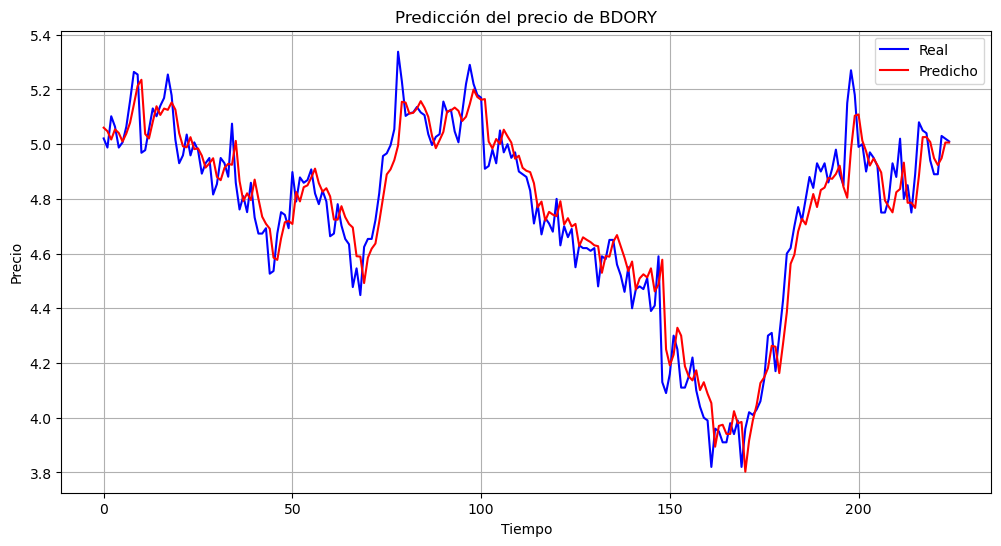

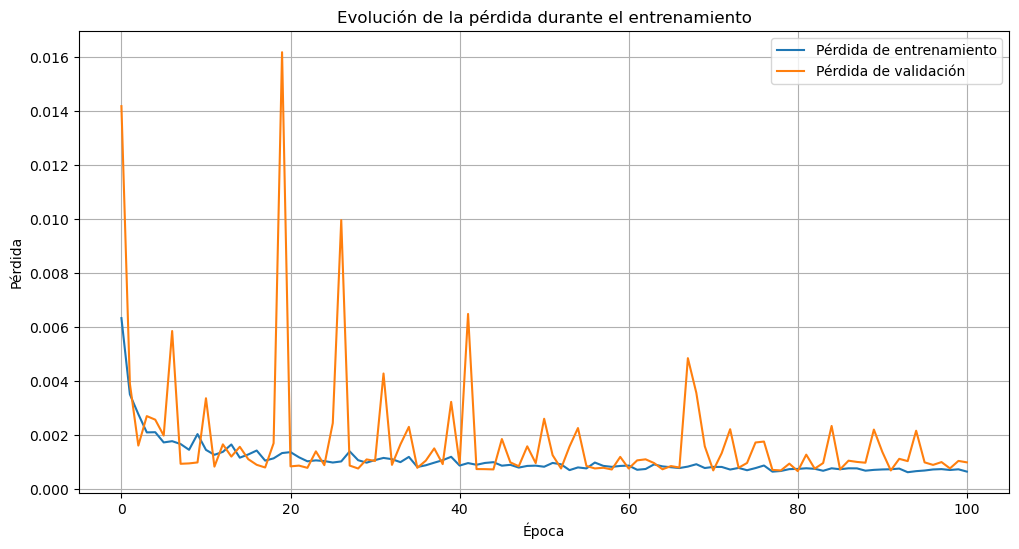

In [32]:
# 1. Descargar datos de yfinance
stock_1 = "BDORY"
stock_2 = "^BVSP"
fecha_inicial = "2020-05-31"  # Fecha histórica
fecha_final = "2025-03-31"    # Fecha actual

df_yf = yf.download(
    tickers=(stock_1, stock_2),
    start=fecha_inicial,
    end=fecha_final,
    interval="1d",
    group_by='ticker',
    auto_adjust=True
)
if df_yf.empty:
	df_yf = pd.read_csv('df_yfinance_raw.csv', header=[0,1], index_col=0, parse_dates=True)

# 2. Crear DataFrame con regresores y características adicionales
df = pd.DataFrame({
    'y': df_yf[stock_1]['Close'],
    'bvsp_lag5': df_yf[stock_2]['Close'].shift(5),
    'volume_BDORY': df_yf[stock_1]['Volume'],
    'high_BDORY': df_yf[stock_1]['High'],
    'low_BDORY': df_yf[stock_1]['Low'],
    'open_BDORY': df_yf[stock_1]['Open']
})
df = df.dropna().reset_index(drop=True)

# Agregar características técnicas
df['returns'] = df['y'].pct_change()
df['volatility'] = df['returns'].rolling(window=5).std()
df['ma5'] = df['y'].rolling(window=5).mean()
df['ma20'] = df['y'].rolling(window=20).mean()

# Eliminar filas con valores nulos
df.dropna(inplace=True)

print(df.head())

print("El modelo no existe. Creando un nuevo modelo...")
# 3. Normalizar los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 4. Crear secuencias para LSTM
def create_sequences(data, seq_length):
	X, y = [], []
	for i in range(seq_length, len(data)):
		X.append(data[i-seq_length:i, :])
		y.append(data[i, 0])  # columna 0 es el precio de cierre de BDORY
	return np.array(X), np.array(y)

sequence_length = 25  # Aumentado para capturar más contexto
X, y = create_sequences(scaled_data, sequence_length)

# 5. Separar en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 6. Construir modelo LSTM mejorado
model_grid_search = Sequential([
	LSTM(units, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
	Dropout(dropout),
	LSTM(128, return_sequences=False),
	Dropout(dropout),
	Dense(56, activation='relu'),
	Dense(1)
])

# Configurar early stopping
callbacks = [
	# detiene el entrenamiento si no hay mejora en la validación
	EarlyStopping(monitor='val_loss', patience=20,restore_best_weights=True),
	# ajusta el learning rate si no hay mejora en la validación
	#ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5) 
]

model_grid_search.compile(optimizer=Adam(learning_rate=lr), loss='mse')

history = model_grid_search.fit(
	X_train, y_train,
	epochs=epochs,
	batch_size=batch_size,
	validation_data=(X_test, y_test),
	callbacks=callbacks,
	verbose=1
) 


# Guardar el historial de entrenamiento
histories['LSTM_grid_search'] = history.history

# 7. Predicciones y desnormalización
predicted = model_grid_search.predict(X_test)
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.zeros((len(y_test),scaled_data.shape[1]-1))), axis=1))[:,0]
predicted_actual = scaler.inverse_transform(np.concatenate((predicted, np.zeros((len(predicted),scaled_data.shape[1]-1))), axis=1))[:,0]

# Guardar las predicciones en el diccionario
predicciones_dict['LSTM_grid_search'] = {'y_test_actual': y_test_actual, 'predicted_actual': predicted_actual}

# 8. Evaluación del modelo
mse = mean_squared_error(y_test_actual, predicted_actual)
mae = mean_absolute_error(y_test_actual, predicted_actual)
r2 = r2_score(y_test_actual, predicted_actual)

# Guardar las métricas en el diccionario
metrics_dict['LSTM_grid_search'] = {'MSE': mse, 'MAE': mae, 'R2': r2}

print(f"\n ### Métricas de evaluación: ###")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

# 9. Visualización
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Real', color='blue')
plt.plot(predicted_actual, label='Predicho', color='red')
plt.title('Predicción del precio de BDORY')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

# 10. Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

### Evolución de la pérdida (loss) en entrenamiento y validación
Muestra si tu modelo está aprendiendo y si hay overfitting.

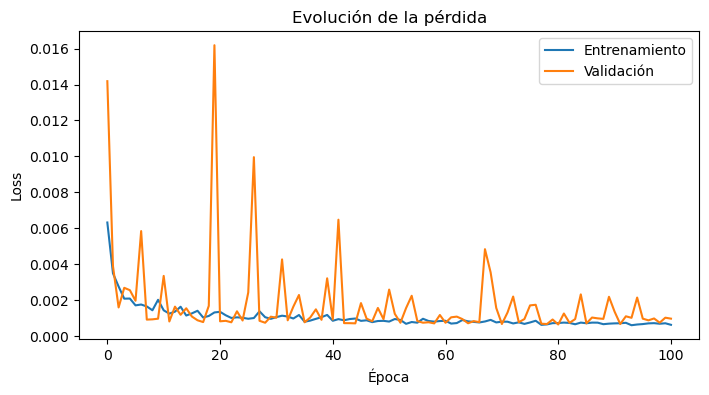

In [33]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Entrenamiento')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de la pérdida')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Valores reales vs. predichos en test (scatter plot)

Permite ver si hay sesgo sistemático y cómo se distribuyen los errores.

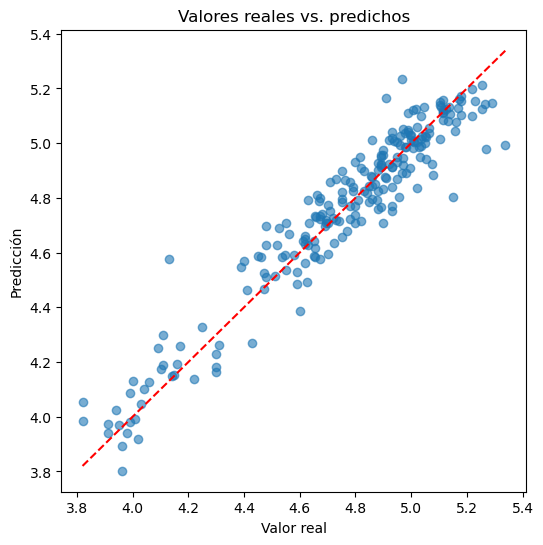

In [34]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_actual, predicted_actual, alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r--')
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.title('Valores reales vs. predichos')
plt.show()


### Errores de predicción a lo largo del tiempo
Útil para detectar períodos donde el modelo falla más.

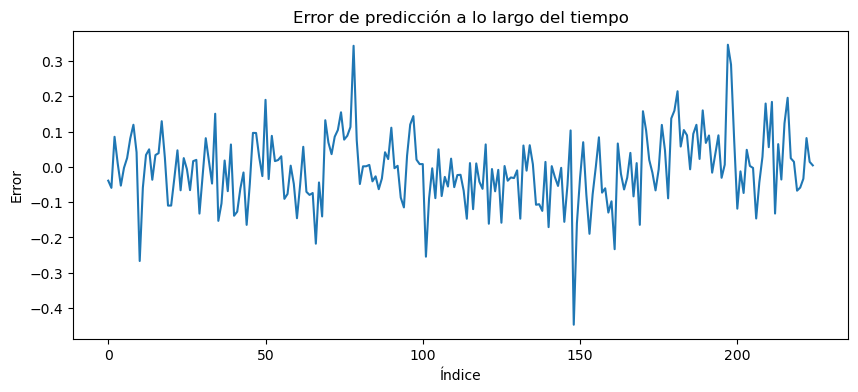

In [35]:
errores = y_test_actual - predicted_actual
plt.figure(figsize=(10,4))
plt.plot(errores)
plt.title('Error de predicción a lo largo del tiempo')
plt.xlabel('Índice')
plt.ylabel('Error')
plt.show()

## Comparo los difrentes entrenamientos

In [36]:
print("histories:", histories)
for version, hist in histories.items():
    print(f"Historial de {version}:")
    for key, values in hist.items():
        print(f"  {key}: {values}")

histories: {'LSTM_simple': {'loss': [0.13706189393997192, 0.044364456087350845, 0.02552882768213749, 0.018912484869360924, 0.01346102636307478, 0.011953801847994328, 0.010487671941518784, 0.00920925848186016, 0.008657993748784065, 0.007976525463163853, 0.006953418720513582, 0.00722472183406353, 0.0070618693716824055, 0.006500911433249712, 0.006498927716165781, 0.00584745965898037, 0.00606955261901021, 0.0052978661842644215, 0.005374216008931398, 0.0057946317829191685, 0.005250346381217241, 0.005785817746073008, 0.006000177003443241, 0.004968819208443165, 0.005111377686262131, 0.004619289189577103, 0.005753449164330959, 0.004861955996602774, 0.00514528714120388, 0.004898740444332361, 0.005011515226215124, 0.004935881122946739, 0.004447734449058771, 0.0045726001262664795, 0.0046178740449249744, 0.004920236766338348, 0.004617762286216021, 0.0052585783414542675, 0.004351852927356958, 0.004629664123058319, 0.004689366556704044, 0.004636214580386877, 0.004365656990557909, 0.00389579287730157

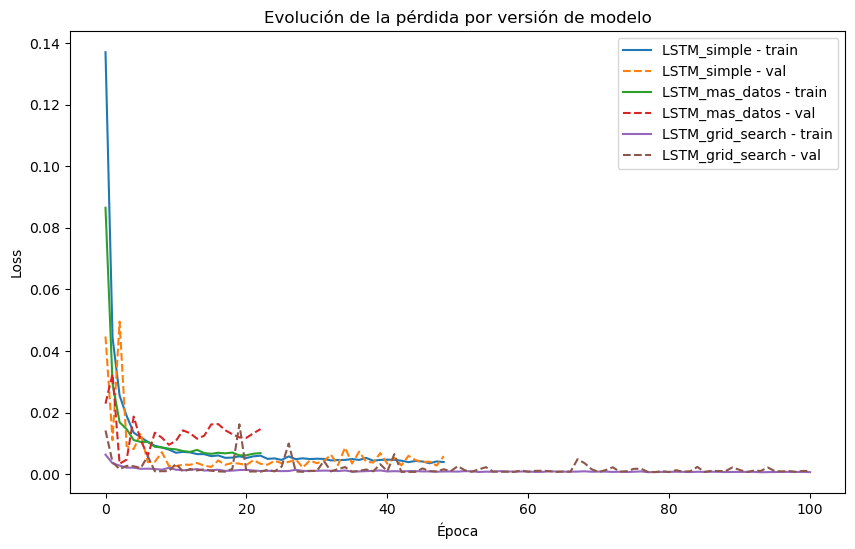

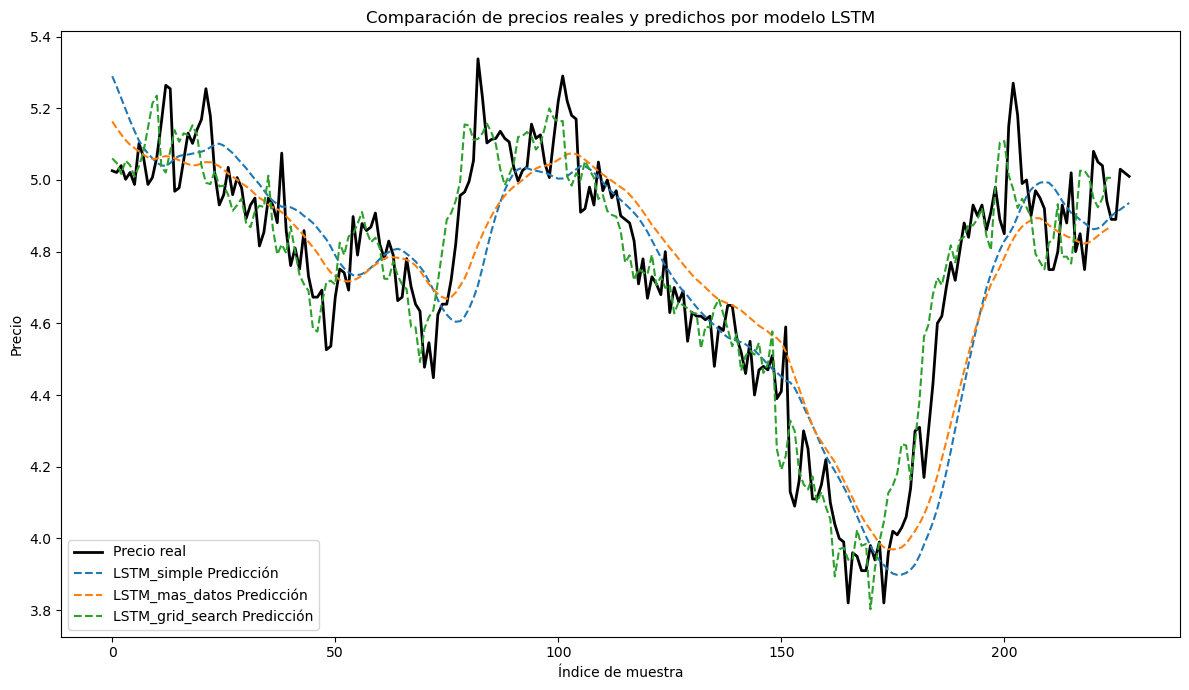

In [ ]:
plt.figure(figsize=(10,6))
for version, hist in histories.items():
    plt.plot(hist['loss'], label=f'{version} - train')
    if 'val_loss' in hist:
        plt.plot(hist['val_loss'], linestyle='--', label=f'{version} - val')
plt.title('Evolución de la pérdida por versión de modelo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the real price only once (using the first model's y_test_actual)
first_key = list(predicciones_dict.keys())[0]
y_real = predicciones_dict[first_key]['y_test_actual']
xs = range(len(y_real))
plt.figure(figsize=(12, 7))
plt.plot(xs, y_real, label='Precio real', color='black', linewidth=2)

# ...existing code...
for model_name, results in predicciones_dict.items():
    y_pred = results['predicted_actual']
    min_len = min(len(xs), len(y_pred))
    plt.plot(xs[:min_len], y_pred[:min_len], label=f'{model_name} Predicción', linestyle='--')
plt.title('Comparación de precios reales y predichos por modelo LSTM')
plt.xlabel('Índice de muestra')
plt.ylabel('Precio')
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
# Convertir el diccionario de métricas a un DataFrame
metrics_df = pd.DataFrame(metrics_dict).T  # Transpone para tener versiones como filas
print(metrics_df)

                       MSE       MAE        R2
LSTM_simple       0.032490  0.134800  0.722689
LSTM_mas_datos    0.051293  0.179191  0.565171
LSTM_grid_search  0.010079  0.074983  0.914561


# Metricas de testeo

## Dataset de testeo

In [40]:
# Define los tickers y el rango de fechas
stock_1 = 'BDORY'
stock_2 = '^BVSP'
fecha_inicial = '2025-04-01'
fecha_final = '2025-06-17' #datetime.today().strftime('%Y-%m-%d')

# Nombre del archivo CSV de respaldo
csv_test_file = 'test_yfinance_data.csv'
df_yf_test = yf.download(
    tickers=(stock_1, stock_2),
    start=fecha_inicial,
    end=fecha_final,
    interval="1d",
    group_by='ticker',
    auto_adjust=True
)

if df_yf_test.empty:
    df_yf_test = pd.read_csv(csv_test_file, header=[0,1], index_col=0, parse_dates=True)

# Asegúrate de que las columnas multi-índice están bien formateadas
df_test = pd.DataFrame({
    'y': df_yf_test[stock_1]['Close'],
    'bvsp_lag5': df_yf_test[stock_2]['Close'].shift(5),
    'volume_BDORY': df_yf_test[stock_1]['Volume'],
    'high_BDORY': df_yf_test[stock_1]['High'],
    'low_BDORY': df_yf_test[stock_1]['Low'],
    'open_BDORY': df_yf_test[stock_1]['Open']
})

# Elimina filas con NaN por el lag
df_test = df_test.dropna().reset_index(drop=True)

# Agregar características técnicas
df_test['returns'] = df_test['y'].pct_change()
df_test['volatility'] = df_test['returns'].rolling(window=5).std()
df_test['ma5'] = df_test['y'].rolling(window=5).mean()
df_test['ma20'] = df_test['y'].rolling(window=20).mean()

# Eliminar filas con valores nulos
df_test.dropna(inplace=True)

# Prepara los datos de testeo igual que en entrenamiento
# Escalar los datos de test (asegúrate de que las columnas y el orden coincidan con el entrenamiento)
scaled_test_data = scaler.transform(df_test)  # Usa el scaler ya entrenado

# Crear secuencias para LSTM (igual que en entrenamiento)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :])
        y.append(data[i, 0])  # columna 0 es el precio de cierre de BDORY
    return np.array(X), np.array(y)

sequence_length = 25  # Debe ser igual al usado en entrenamiento
X_test, y_test = create_sequences(scaled_test_data, sequence_length)


[*********************100%***********************]  2 of 2 completed


## Testeo de los modelos

In [44]:
# Predecir
predicted = model_grid_search.predict(X_test)

# Desescalar los resultados SOLO para la columna 'y'
import numpy as np
y_test_actual = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1,1), np.zeros((len(y_test), scaled_data.shape[1]-1))), axis=1)
)[:,0]
predicted_actual = scaler.inverse_transform(
    np.concatenate((predicted, np.zeros((len(predicted), scaled_data.shape[1]-1))), axis=1)
)[:,0]

# 5. Calcula métricas
mse = mean_squared_error(y_test_actual, predicted_actual)
mae = mean_absolute_error(y_test_actual, predicted_actual)
r2 = r2_score(y_test_actual, predicted_actual)

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R2: {r2:.6f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
MSE: 0.019282
MAE: 0.120455
R2: -2.427862


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


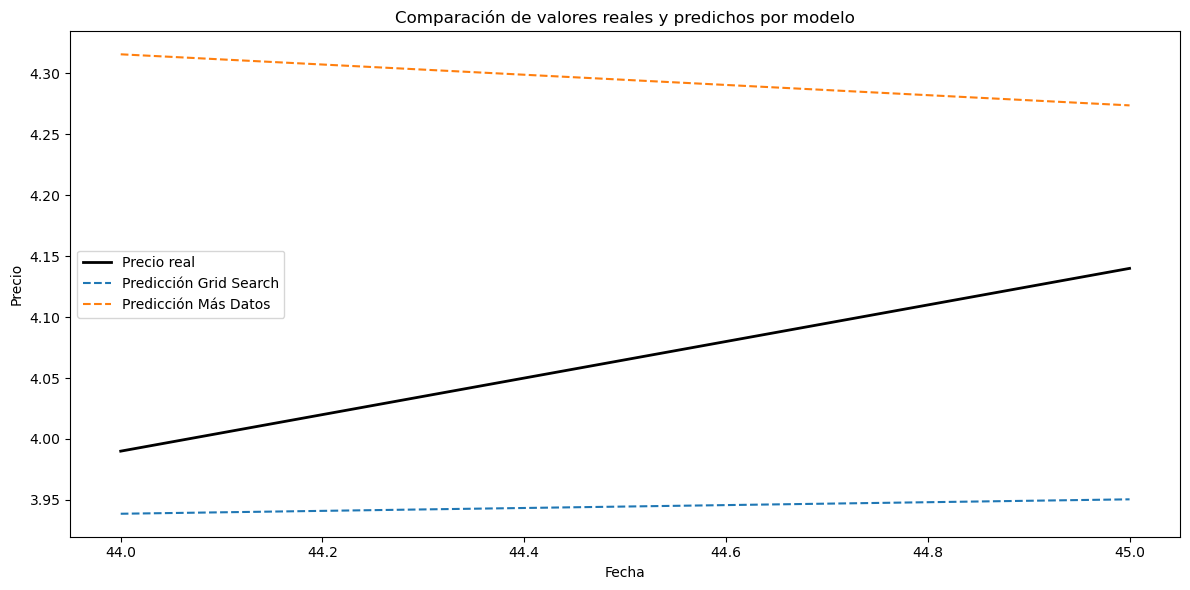

In [45]:
# 1. Predict and descale for each model
models = {
    'Grid Search': model_grid_search,
    #'Basic': model_basic,
    'Más Datos': model_mas_datos
}

predictions = {}

for model_name, model in models.items():
    predicted = model.predict(X_test)
    predicted_actual = scaler.inverse_transform(
        np.concatenate((predicted, np.zeros((len(predicted), scaled_data.shape[1]-1))), axis=1)
    )[:,0]
    predictions[model_name] = predicted_actual

# 2. Descales the real test values only once
y_test_actual = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1,1), np.zeros((len(y_test), scaled_data.shape[1]-1))), axis=1)
)[:,0]

# 3. Align the index
aligned_index = df_test.index[sequence_length:]

# 4. Plot
plt.figure(figsize=(12,6))
plt.plot(aligned_index, y_test_actual, label='Precio real', color='black', linewidth=2)
for model_name, y_pred in predictions.items():
    plt.plot(aligned_index, y_pred, label=f'Predicción {model_name}', linestyle='--')
plt.title('Comparación de valores reales y predichos por modelo')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.tight_layout()
plt.show()
